# 04 Hyperparameter tuning

In this notebook we tune the hyperparameters of the models to maximize their performance.

## Reading data

We read the preprocessed data from the pickle file we created in step 03.

In [1]:
# Basic packages
import numpy as np
import pandas as pd

import matplotlib.pyplot as plt
import seaborn as sns

# Catboost
import catboost
from catboost import CatBoostRegressor
from catboost import Pool

# XGBoost
from xgboost import XGBRegressor
from xgboost import plot_importance

# Random Forest
from sklearn.ensemble import RandomForestRegressor

# Linear regression
from sklearn.linear_model import LinearRegression

# Linear SVR
from sklearn.svm import LinearSVR

# Utils
from sklearn.model_selection import ParameterGrid
from sklearn.preprocessing import StandardScaler, MinMaxScaler
from sklearn.metrics import mean_squared_error
import pickle
import time

In [2]:
file = open('data/processed-data.pickle', 'rb')
data = pickle.load(file)

X_train = data['X_train']
y_train = data['y_train']
X_validation = data['X_validation']
y_validation = data['y_validation']
X_test = data['X_test']
test = data['test']

## Random Forest

In [66]:
rf_features = ['shop_id', 'item_id', 'item_cnt', 'mean_item_cnt', 'transactions', 'year', 'item_cnt_prev_month_1', 'item_cnt_prev_mean', 'item_cnt_prev_std', 'item_trend', 'shop_mean', 'item_mean']

rf_train = X_train[rf_features]
rf_val = X_validation[rf_features]
rf_test = X_test[rf_features]

In [72]:
rf_hyperparam_grid = {
    'n_estimators': [20, 50, 100],
    'max_depth': [3, 5, 7, 9]
}

rf_models = {}

In [69]:
# Iterate over all combinations of hyperparameters
for params in ParameterGrid(rf_hyperparam_grid):
    # Unique model identifier
    key = str(params['n_estimators']) + 'x' + str(params['max_depth'])

    # Don't retrain if already trained
    if key in rf_models:
        continue

    # Initialization with given hyperparameters
    print('Training', key, end='. ')
    rf_models[key] = {
        'model': RandomForestRegressor(
            n_estimators=params['n_estimators'],
            max_depth=params['max_depth'],
            random_state=0
        )
    }

    # Training
    t = time.time()
    rf_models[key]['model'].fit(rf_train, y_train)
    rf_models[key]['time'] = time.time() - t
    print('Time:', round(rf_models[key]['time'], 2), 's', end='. ')

    # Validation
    rf_models[key]['preds'] = rf_models[key]['model'].predict(rf_val)
    rf_models[key]['error'] = np.sqrt(mean_squared_error(y_validation, rf_models[key]['preds']))
    print('Error:',  round(rf_models[key]['error'], 4))

Training {'max_depth': 3, 'n_estimators': 20}. 

In [15]:
def plot_heatmap(models, hyperparam_grid, field):
    hyperparams = list(hyperparam_grid.keys())

    values = pd.DataFrame(index=hyperparam_grid[hyperparams[0]][::-1], columns=hyperparam_grid[hyperparams[1]], dtype='float64')
    for params in ParameterGrid(hyperparam_grid):
        key = str(params[hyperparams[0]]) + 'x' + str(params[hyperparams[1]])
        values.loc[params[hyperparams[0]], params[hyperparams[1]]] = models[key][field]

    sns.heatmap(values, annot=True, fmt='.4f', cmap='coolwarm')
    plt.xlabel(hyperparams[1])
    plt.ylabel(hyperparams[0])

plot_heatmap(rf_models, rf_hyperparam_grid, 'error')

NameError: name 'rf_models' is not defined

In [39]:
# Choose best based on least error
rf_errors = {key: rf_models[key]['error'] for key in rf_models}
rf_best = rf_models[min(rf_errors, key=rf_errors.get)]

# Choose best manually
rf_best = rf_models['20x5']

# Generate predictions for submission
rf_test_pred = rf_best['model'].predict(rf_test)

{'model': RandomForestRegressor(max_depth=5, n_estimators=20, random_state=0),
 'time': 101.40521907806396,
 'preds': array([0.28551432, 0.28551432, 0.28551432, ..., 0.31429874, 0.31429874,
        0.31429874]),
 'error': 1.0281898985040585}

## Catboost

In [21]:
# Specify indices for categorical features: shop_id, item_id, year and month
cb_features = [0, 1, 7, 8]

cb_hyperparam_grid = {
    'depth': [2, 3, 4],
    'max_ctr_complexity': [3, 5]
}

cb_models = {}

In [22]:
# Iterate over all combinations of hyperparameters
for params in ParameterGrid(cb_hyperparam_grid):
    # Unique model identifier
    key = str(params['depth']) + 'x' + str(params['max_ctr_complexity'])

    # Don't retrain if already trained
    if key in cb_models:
        continue

    # Initialization with given hyperparameters
    print('Training', params, end='. ')
    cb_models[key] = {
        'model': CatBoostRegressor(
            depth=params['depth'],
            max_ctr_complexity=params['max_ctr_complexity'],
            od_type='Iter',
            verbose=0,
            random_seed=0
        )
    }

    # Training
    t = time.time()
    cb_models[key]['model'].fit(
        X_train, y_train,
        cat_features=cb_features,
        eval_set=(X_validation, y_validation)
    )
    cb_models[key]['time'] = time.time() - t
    print('Time:', round(cb_models[key]['time'], 2), 's', end='. ')

    # Validation
    cb_models[key]['preds'] = cb_models[key]['model'].predict(X_validation)
    cb_models[key]['error'] = np.sqrt(mean_squared_error(y_validation, cb_models[key]['preds']))
    print('Error:',  round(cb_models[key]['error'], 4))

Training {'depth': 2, 'max_ctr_complexity': 3}. Time: 65.91 s. Error: 1.0513
Training {'depth': 2, 'max_ctr_complexity': 5}. Time: 73.64 s. Error: 1.0513
Training {'depth': 3, 'max_ctr_complexity': 3}. Time: 76.28 s. Error: 1.0558
Training {'depth': 3, 'max_ctr_complexity': 5}. Time: 63.35 s. Error: 1.0558
Training {'depth': 4, 'max_ctr_complexity': 3}. Time: 81.85 s. Error: 1.0667
Training {'depth': 4, 'max_ctr_complexity': 5}. Time: 91.73 s. Error: 1.0659


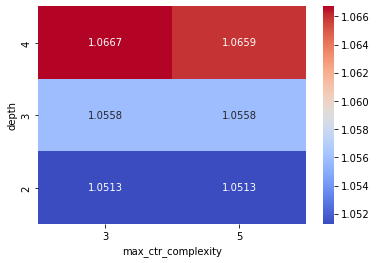

In [23]:
plot_heatmap(cb_models, cb_hyperparam_grid, 'error')

In [26]:
# Choose best based on least error
cb_errors = {key: cb_models[key]['error'] for key in cb_models}
cb_best = cb_models[min(cb_errors, key=cb_errors.get)]

# Generate predictions for submission
cb_test_pred = cb_best['model'].predict(X_test)

## XGBoost

In [132]:
# Use only part of features on XGBoost.
xgb_features = ['item_cnt','item_cnt_prev_mean', 'item_cnt_prev_std', 'item_cnt_prev_month_1',
                'item_cnt_prev_month_2', 'item_cnt_prev_month_3', 'shop_mean',
                'shop_item_mean', 'item_trend', 'mean_item_cnt']
xgb_train = X_train[xgb_features]
xgb_val = X_validation[xgb_features]
xgb_test = X_test[xgb_features]

In [133]:
xgb_model = XGBRegressor(max_depth=8,
                         n_estimators=500,
                         min_child_weight=1000,
                         colsample_bytree=0.7,
                         subsample=0.7,
                         eta=0.3,
                         seed=0)
xgb_model.fit(xgb_train,
              y_train,
              eval_metric="rmse",
              eval_set=[(xgb_train, y_train), (xgb_val, y_validation)],
              verbose=20,
              early_stopping_rounds=20)

[0]	validation_0-rmse:1.08221	validation_1-rmse:1.14058
[20]	validation_0-rmse:0.89718	validation_1-rmse:1.09418
[27]	validation_0-rmse:0.89613	validation_1-rmse:1.10067


XGBRegressor(base_score=0.5, booster='gbtree', colsample_bylevel=1,
             colsample_bynode=1, colsample_bytree=0.7, eta=0.3, gamma=0,
             gpu_id=-1, importance_type='gain', interaction_constraints='',
             learning_rate=0.300000012, max_delta_step=0, max_depth=8,
             min_child_weight=1000, missing=nan, monotone_constraints='()',
             n_estimators=500, n_jobs=4, num_parallel_tree=1, random_state=0,
             reg_alpha=0, reg_lambda=1, scale_pos_weight=1, seed=0,
             subsample=0.7, tree_method='exact', validate_parameters=1,
             verbosity=None)

<AxesSubplot:title={'center':'Feature importance'}, xlabel='F score', ylabel='Features'>

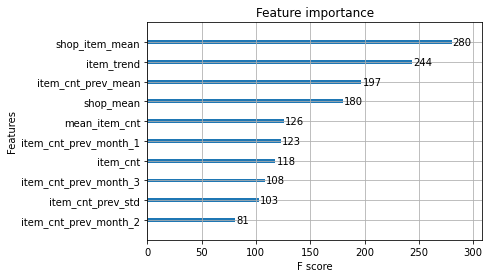

In [134]:
plot_importance(xgb_model)

In [135]:
xgb_train_pred = xgb_model.predict(xgb_train)
xgb_val_pred = xgb_model.predict(xgb_val)
xgb_test_pred = xgb_model.predict(xgb_test)

In [136]:
print('Train rmse:', np.sqrt(mean_squared_error(y_train, xgb_train_pred)))
print('Validation rmse:', np.sqrt(mean_squared_error(y_validation, xgb_val_pred)))

Train rmse: 0.9063084111241146
Validation rmse: 1.0634839415658868


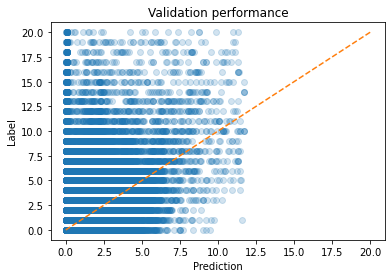

In [137]:
plot_model_performance(xgb_val_pred, y_validation, 'Validation performance')

## Linear regression

In [143]:
lr_features = ['item_cnt', 'item_cnt_prev_month_1', 'item_trend', 'mean_item_cnt', 'shop_mean']

lr_train = X_train[lr_features]
lr_val = X_validation[lr_features]
lr_test = X_test[lr_features]

In [144]:
# Normalizing
lr_scaler = MinMaxScaler()
lr_scaler.fit(lr_train)

lr_train = lr_scaler.transform(lr_train)
lr_val = lr_scaler.transform(lr_val)
lr_test = lr_scaler.transform(lr_test)

In [145]:
lr_model = LinearRegression()
lr_model.fit(lr_train, y_train)

LinearRegression()

In [146]:
lr_train_pred = lr_model.predict(lr_train)
lr_val_pred = lr_model.predict(lr_val)
lr_test_pred = lr_model.predict(lr_test)

In [147]:
print('Train rmse:', np.sqrt(mean_squared_error(y_train, lr_train_pred)))
print('Validation rmse:', np.sqrt(mean_squared_error(y_validation, lr_val_pred)))

Train rmse: 0.96557127056507
Validation rmse: 1.0128629563995037


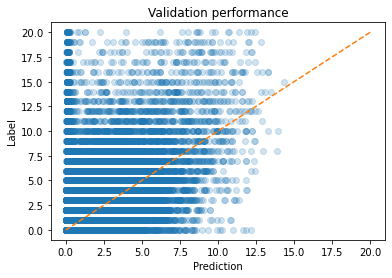

In [148]:
plot_model_performance(lr_val_pred, y_validation, 'Validation performance')

## Linear SVR

In [149]:
lsvr_features = ['item_cnt', 'item_cnt_prev_mean', 'item_cnt_prev_std', 'item_cnt_prev_month_1', 'shop_mean', 'shop_item_mean', 'mean_item_cnt']

lsvr_train = X_train[lsvr_features]
lsvr_val = X_validation[lsvr_features]
lsvr_test = X_test[lsvr_features]

In [150]:
# Normalizing
lsvr_scaler = MinMaxScaler()
lsvr_scaler.fit(lsvr_train)

lsvr_train = lsvr_scaler.transform(lsvr_train)
lsvr_val = lsvr_scaler.transform(lsvr_val)
lsvr_test = lsvr_scaler.transform(lsvr_test)

In [151]:
lsvr_model = LinearSVR()
lsvr_model.fit(lsvr_train, y_train)

LinearSVR(C=1)

In [152]:
lsvr_train_pred = lsvr_model.predict(lsvr_train)
lsvr_val_pred = lsvr_model.predict(lsvr_val)
lsvr_test_pred = lsvr_model.predict(lsvr_test)

In [153]:
print('Train rmse:', np.sqrt(mean_squared_error(y_train, lsvr_train_pred)))
print('Validation rmse:', np.sqrt(mean_squared_error(y_validation, lsvr_val_pred)))

Train rmse: 1.0018868456518795
Validation rmse: 1.053649239114253


## Ensembling

In [154]:
# Validation data becomes the training data for the ensembling step
X_train_ensembling = pd.DataFrame({
    'catboost': cb_val_pred,
    'xgboost': xgb_val_pred,
    'random_forest': rf_val_pred,
    'linear_regression': lr_val_pred,
    'lsvr': lsvr_val_pred
})

y_train_ensembling = y_validation

In [155]:
# Test data is the test data for the ensembling step
X_test_ensembling = pd.DataFrame({
    'catboost': catboost_test_pred,
    'xgboost': xgb_test_pred,
    'random_forest': rf_test_pred,
    'linear_regression': lr_test_pred,
    'lsvr': lsvr_test_pred
})

In [156]:
ensembling_model = LinearRegression()
ensembling_model.fit(X_train_ensembling, y_train_ensembling)

LinearRegression()

In [157]:
ensemble_train_pred = ensembling_model.predict(X_train_ensembling)
ensemble_test_pred = ensembling_model.predict(X_test_ensembling)

In [158]:
print('Train rmse:', np.sqrt(mean_squared_error(ensemble_train_pred, y_train_ensembling)))

Train rmse: 1.005152328579565


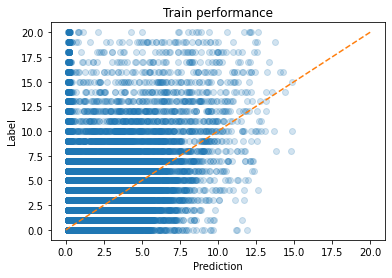

In [159]:
plot_model_performance(ensemble_train_pred, y_train_ensembling, 'Train performance')

## Submission

We finally generate the csv file ready for submission.

In [27]:
def generate_submission_file(data, pred_field, filename='submission.csv'):
    predictions = pd.merge(test, data, on=['shop_id', 'item_id'], how='left').fillna(0)

    output = pd.DataFrame({'ID': predictions['ID'], 'item_cnt_month': predictions[pred_field]})
    output.to_csv('predictions/' + filename, index=False)

In [28]:
X_test['item_cnt_next_month'] = cb_test_pred
generate_submission_file(X_test, 'item_cnt_next_month', 'catboost.csv')

In [161]:
X_test['item_cnt_next_month'] = cb_test_pred
generate_submission_file(X_test, 'item_cnt_next_month', 'catboost.csv')

X_test['item_cnt_next_month'] = xgb_test_pred
generate_submission_file(X_test, 'item_cnt_next_month', 'xgboost.csv')

X_test['item_cnt_next_month'] = rf_test_pred
generate_submission_file(X_test, 'item_cnt_next_month', 'random-forest.csv')

X_test['item_cnt_next_month'] = lr_test_pred
generate_submission_file(X_test, 'item_cnt_next_month', 'linear-regression.csv')

X_test['item_cnt_next_month'] = lsvr_test_pred
generate_submission_file(X_test, 'item_cnt_next_month', 'linear-svr.csv')

X_test['item_cnt_next_month'] = ensemble_test_pred
generate_submission_file(X_test, 'item_cnt_next_month', 'ensemble.csv')